# INSTALLING REQUIRED PACKAGES

In [4]:
# Install required packages
!pip install scikit-learn nltk matplotlib wordcloud

# Download NLTK data
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pratikmanpradhan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pratikmanpradhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pratikmanpradhan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/pratikmanpradhan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/pratikmanpradhan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## IMPORTING REQUIRED LIBRARIES

In [6]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import re
from wordcloud import WordCloud

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Settings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')


## LOAD DATASET

In [8]:
# Load dataset
df = pd.read_csv('train-balanced-sarcasm.csv')


print(f"Total rows: {len(df):,}")
print(f"Total columns: {df.shape[1]}")
print(f"\nColumn names:")
print(df.columns.tolist())

Total rows: 1,010,826
Total columns: 10

Column names:
['label', 'comment', 'author', 'subreddit', 'score', 'ups', 'downs', 'date', 'created_utc', 'parent_comment']


## DATASET PREVIEW

In [139]:
# Display first few rows
print("First 5 samples:")
df.head()

First 5 samples:


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


## DATASET INFO

In [12]:
print(f"Missing values:\n{df.isnull().sum()}")
print(f"\nDuplicate rows: {df.duplicated().sum()}")
print(f"\nClass distribution:\n{df['label'].value_counts()}")

Missing values:
label              0
comment           55
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

Duplicate rows: 28

Class distribution:
label
0    505413
1    505413
Name: count, dtype: int64


# DATA CLEANING

## Before Cleaning

In [15]:
# Check which rows have missing comment
print(f"Total rows: {len(df):,}")
print(f"Missing 'comment': {df['comment'].isnull().sum():,}")
print(f"Duplicate rows: {df.duplicated().sum()}")

Total rows: 1,010,826
Missing 'comment': 55
Duplicate rows: 28


## Cleaning steps

In [17]:
# Drop rows with missing comment 
df = df.dropna(subset=['comment'])

# Drop duplicates
df = df.drop_duplicates()

## After Cleaning

In [19]:
print(f"Total rows: {len(df):,}")
print(f"Missing 'comment': {df['comment'].isnull().sum():,}")

# Keep only needed columns
df_clean = df[['comment', 'label']].copy()

print(f"Cleaned dataset shape: {df_clean.shape}")

Total rows: 1,010,743
Missing 'comment': 0
Cleaned dataset shape: (1010743, 2)


# SAMPLING DATA

In [21]:
# Sample 50,000 from each class (100k total)
df_sample = df_clean.groupby('label', group_keys=False).apply(
    lambda x: x.sample(50000, random_state=42)
)

## Sample data size

In [23]:
print(f"Sampled dataset size: {len(df_sample):,}")
print(f"Class distribution:")
print(df_sample['label'].value_counts())

Sampled dataset size: 100,000
Class distribution:
label
0    50000
1    50000
Name: count, dtype: int64


# Text Preprocessing

In [25]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


print(f"Total stopwords: {len(stop_words)}")

Total stopwords: 198


### Basic Cleaning

In [27]:
cleaned_texts = []

for idx, text in enumerate(df_sample['comment']):

    text = str(text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove user mentions
    text = re.sub(r'@\w+', '', text)
    
    cleaned_texts.append(text)

df_sample['cleaned_text'] = cleaned_texts

## Remove Special Characters

In [29]:
cleaned_texts = []

for text in df_sample['cleaned_text']:
    # Keep only letters and spaces
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    cleaned_texts.append(text)

df_sample['cleaned_text'] = cleaned_texts

## Tokenization and Lemmatization

In [31]:
final_texts = []

for idx, text in enumerate(df_sample['cleaned_text']):
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens 
              if word not in stop_words and len(word) > 2]
    
    final_texts.append(' '.join(tokens))

df_sample['cleaned_text'] = final_texts

# Remove empty texts
df_sample = df_sample[df_sample['cleaned_text'].str.len() > 0]



In [32]:
print(f"Final dataset size: {len(df_sample):,}")

Final dataset size: 98,670


## Train-Test Split


In [34]:
# Features and labels
X = df_sample['cleaned_text']
y = df_sample['label']

# Split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

In [35]:
print(f"Training set size: {len(X_train):,}")
print(f"Testing set size: {len(X_test):,}")
print(f"Training labels distribution:")
print(y_train.value_counts())
print(f"Testing labels distribution:")
print(y_test.value_counts())

Training set size: 78,936
Testing set size: 19,734
Training labels distribution:
label
1    39809
0    39127
Name: count, dtype: int64
Testing labels distribution:
label
1    9952
0    9782
Name: count, dtype: int64


## APPLYING TF-IDF Vectorization

In [37]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
)

# Fit and transform training data
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform test data
X_test_tfidf = tfidf.transform(X_test)

In [38]:
print(f"Training data shape: {X_train_tfidf.shape}")
print(f"Testing data shape: {X_test_tfidf.shape}")

Training data shape: (78936, 5000)
Testing data shape: (19734, 5000)


## Model Training
Training two models: Logistic Regression and Random Forest

In [40]:
# Create and train Logistic Regression
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

lr_model.fit(X_train_tfidf, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

## Make Prediction using LR

In [42]:
y_pred_lr = lr_model.predict(X_test_tfidf)

print(f"\nPredictions made: {len(y_pred_lr):,}")
print(f"Predicted sarcastic (1): {sum(y_pred_lr == 1):,}")
print(f"Predicted non-sarcastic (0): {sum(y_pred_lr == 0):,}")


Predictions made: 19,734
Predicted sarcastic (1): 9,220
Predicted non-sarcastic (0): 10,514


In [43]:
# Create and train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    max_depth=20,
    min_samples_split=10
)
rf_model.fit(X_train_tfidf, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",10
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(

## Make Prediction using RF

In [45]:
y_pred_rf = rf_model.predict(X_test_tfidf)

print(f"\nPredictions made: {len(y_pred_rf):,}")
print(f"Predicted sarcastic (1): {sum(y_pred_rf == 1):,}")
print(f"Predicted non-sarcastic (0): {sum(y_pred_rf == 0):,}")


Predictions made: 19,734
Predicted sarcastic (1): 6,482
Predicted non-sarcastic (0): 13,252


# MODEL EVALUATION

## Logistic Regression Evaluation

In [107]:
# Calculate metrics
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)

print(f"Accuracy:  {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall:    {lr_recall:.4f}")
print(f"F1-Score:  {lr_f1:.4f}")

print()
print("Classification Report of Logistic Regression:")
print()
print(classification_report(y_test, y_pred_lr, target_names=['Non-Sarcastic', 'Sarcastic']))


Accuracy:  0.6604 (66.04%)
Precision: 0.6762
Recall:    0.6265
F1-Score:  0.6504

Classification Report of Logistic Regression:

               precision    recall  f1-score   support

Non-Sarcastic       0.65      0.69      0.67      9782
    Sarcastic       0.68      0.63      0.65      9952

     accuracy                           0.66     19734
    macro avg       0.66      0.66      0.66     19734
 weighted avg       0.66      0.66      0.66     19734



## Random Forest Regression

In [109]:
# Calculate metrics
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

print(f"Accuracy:  {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall:    {rf_recall:.4f}")
print(f"F1-Score:  {rf_f1:.4f}")

print()
print("Classification Report of Random Forest Regression:")
print()
print(classification_report(y_test, y_pred_rf, target_names=['Non-Sarcastic', 'Sarcastic']))

Accuracy:  0.6294 (62.94%)
Precision: 0.7035
Recall:    0.4582
F1-Score:  0.5549

Classification Report of Random Forest Regression:

               precision    recall  f1-score   support

Non-Sarcastic       0.59      0.80      0.68      9782
    Sarcastic       0.70      0.46      0.55      9952

     accuracy                           0.63     19734
    macro avg       0.65      0.63      0.62     19734
 weighted avg       0.65      0.63      0.62     19734



# Model Comparison

In [137]:
comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [lr_accuracy, rf_accuracy],
    'Precision': [lr_precision, rf_precision],
    'Recall': [lr_recall, rf_recall],
    'F1-Score': [lr_f1, rf_f1]
})

print(comparison.to_string(index=False))

best_model = comparison.loc[comparison['Accuracy'].idxmax(), 'Model']
print()
print(f"Best Model: {best_model}")
print(f"Best Accuracy: {comparison['Accuracy'].max():.4f} ({comparison['Accuracy'].max()*100:.2f}%)")

              Model  Accuracy  Precision   Recall  F1-Score
Logistic Regression  0.660383   0.676247 0.626507  0.650428
      Random Forest  0.629371   0.703487 0.458199  0.554947

Best Model: Logistic Regression
Best Accuracy: 0.6604 (66.04%)


# Confusion Matrices

### Logistic Regression 

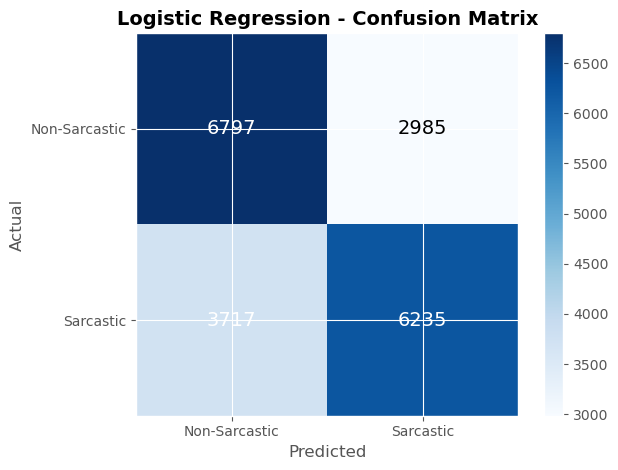

In [55]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns_cmap = plt.cm.Blues
plt.imshow(cm_lr, interpolation='nearest', cmap=sns_cmap)
plt.title('Logistic Regression - Confusion Matrix', fontsize=14, fontweight='bold')

# Add text annotations
for i in range(cm_lr.shape[0]):
    for j in range(cm_lr.shape[1]):
        plt.text(j, i, format(cm_lr[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm_lr[i, j] > cm_lr.max() / 2 else "black",
                fontsize=14)

plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.xticks([0, 1], ['Non-Sarcastic', 'Sarcastic'])
plt.yticks([0, 1], ['Non-Sarcastic', 'Sarcastic'])
plt.colorbar()
plt.tight_layout()
plt.show()

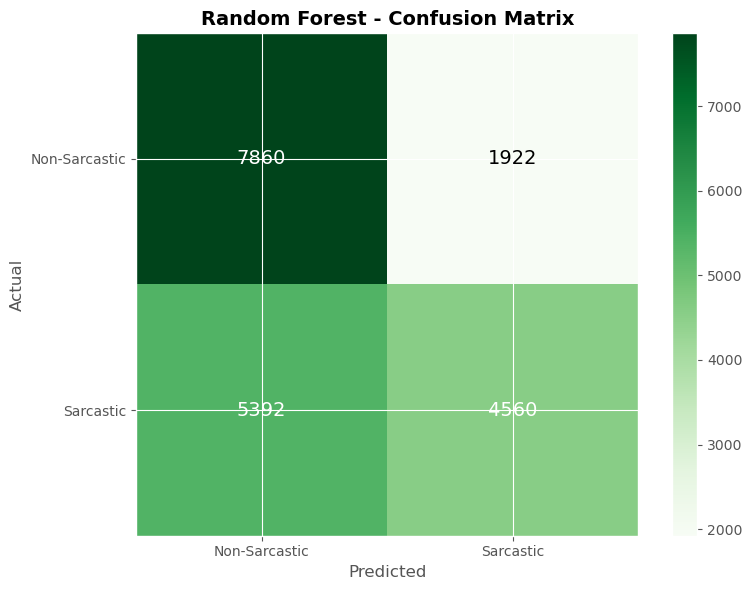

In [56]:
plt.figure(figsize=(8, 6))

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns_cmap = plt.cm.Greens
plt.imshow(cm_rf, interpolation='nearest', cmap=sns_cmap)
plt.title('Random Forest - Confusion Matrix', fontsize=14, fontweight='bold')

# Add text annotations
for i in range(cm_rf.shape[0]):
    for j in range(cm_rf.shape[1]):
        plt.text(j, i, format(cm_rf[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm_rf[i, j] > cm_rf.max() / 2 else "black",
                fontsize=14)

plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.xticks([0, 1], ['Non-Sarcastic', 'Sarcastic'])
plt.yticks([0, 1], ['Non-Sarcastic', 'Sarcastic'])
plt.colorbar()
plt.tight_layout()
plt.show()

## ROC Curves

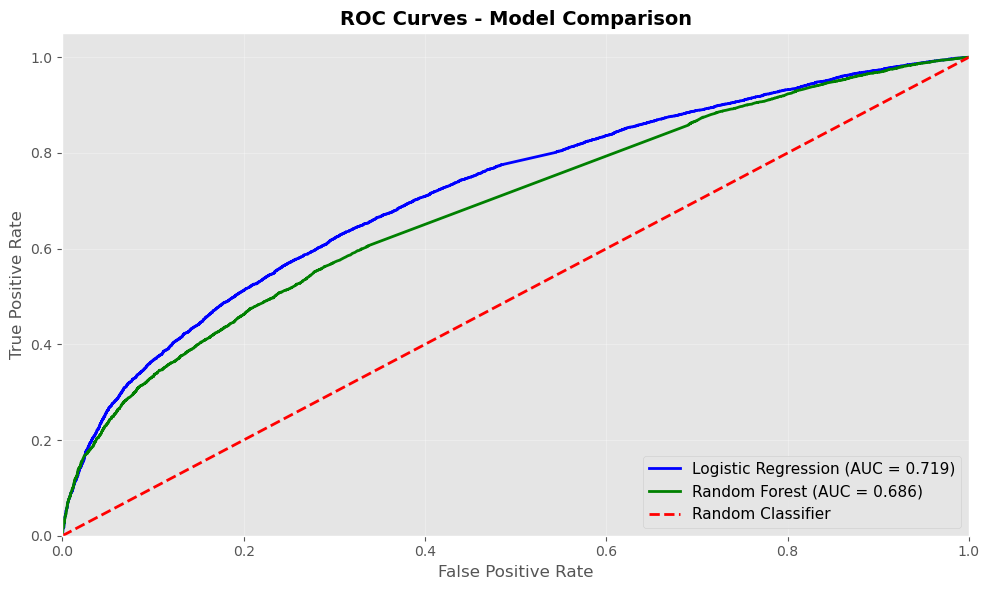

In [58]:
# Get prediction probabilities
y_pred_lr_proba = lr_model.predict_proba(X_test_tfidf)[:, 1]
y_pred_rf_proba = rf_model.predict_proba(X_test_tfidf)[:, 1]

# Calculate ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr_proba)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_proba)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC Curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, 
         label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2,
         label=f'Random Forest (AUC = {roc_auc_rf:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Precison Recall Curve

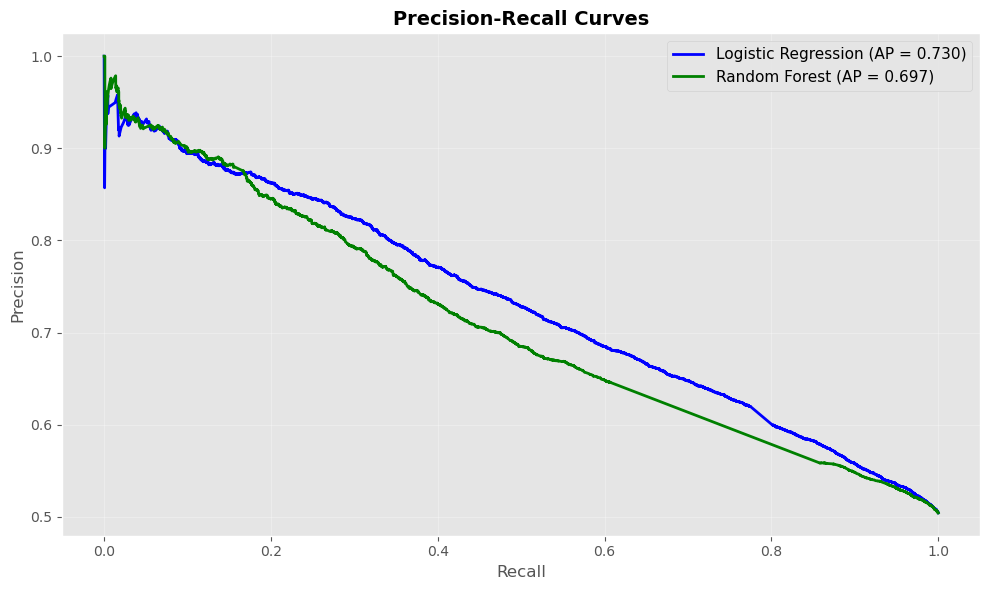

In [60]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_lr_proba)
ap_lr = average_precision_score(y_test, y_pred_lr_proba)

precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_rf_proba)
ap_rf = average_precision_score(y_test, y_pred_rf_proba)

plt.figure(figsize=(10, 6))
plt.plot(recall_lr, precision_lr, color='blue', lw=2,
         label=f'Logistic Regression (AP = {ap_lr:.3f})')
plt.plot(recall_rf, precision_rf, color='green', lw=2,
         label=f'Random Forest (AP = {ap_rf:.3f})')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves', fontsize=14, fontweight='bold')
plt.legend(loc="best", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Model Performance Comparision Bar Chart

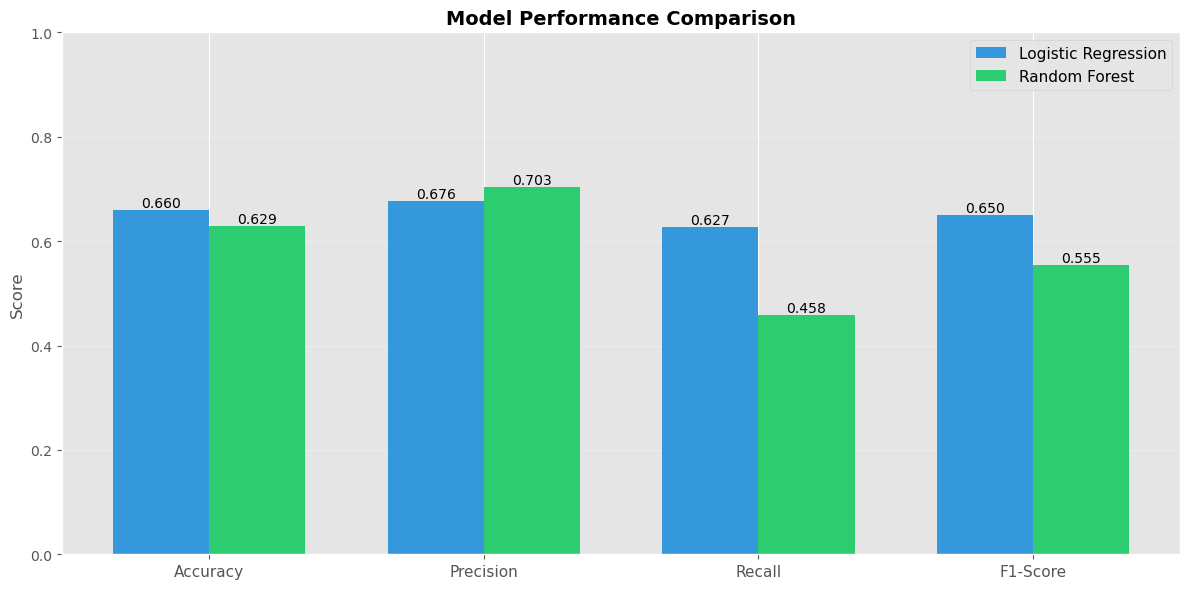

In [62]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
lr_scores = [lr_accuracy, lr_precision, lr_recall, lr_f1]
rf_scores = [rf_accuracy, rf_precision, rf_recall, rf_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, lr_scores, width, label='Logistic Regression', color='#3498db')
bars2 = ax.bar(x + width/2, rf_scores, width, label='Random Forest', color='#2ecc71')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend(fontsize=11)
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### TOP TF-IDF Features Visualization

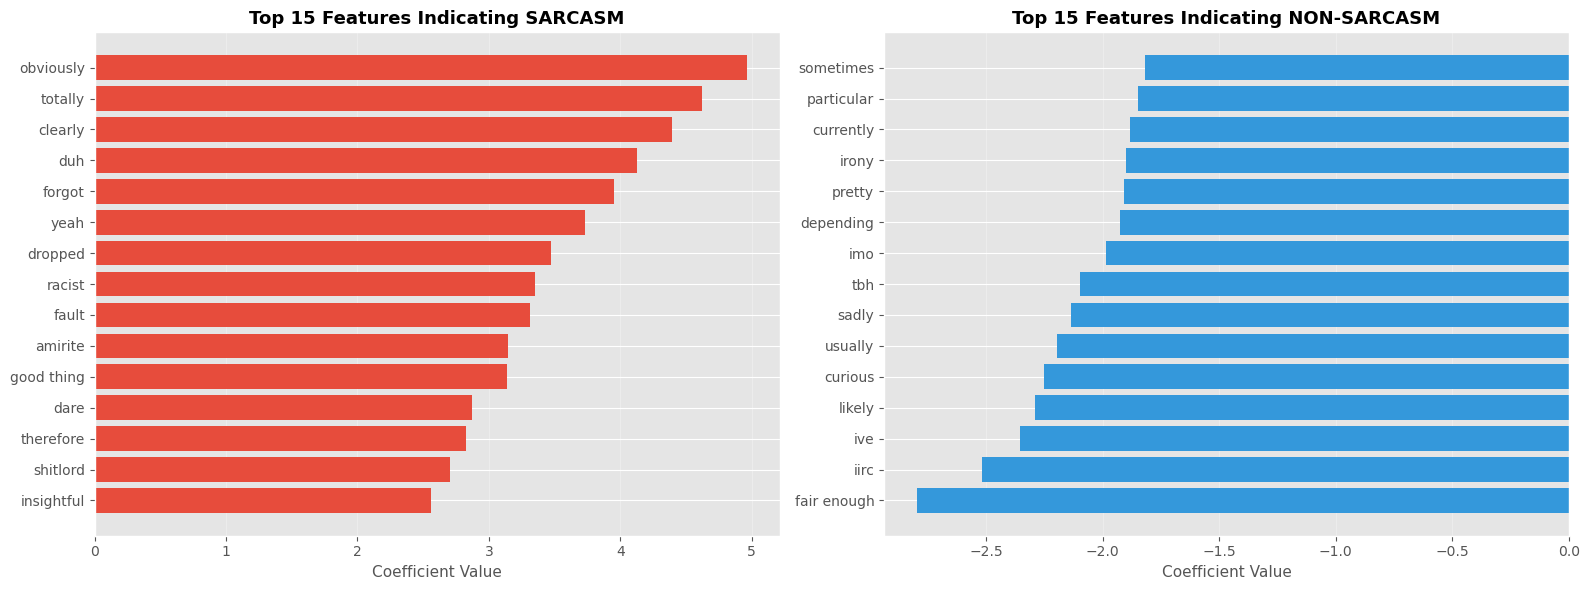

In [64]:
# Get feature names and their importance
feature_names = tfidf.get_feature_names_out()

# For Logistic Regression - get coefficients
lr_coef = lr_model.coef_[0]
top_positive_idx = np.argsort(lr_coef)[-15:]
top_negative_idx = np.argsort(lr_coef)[:15]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top Sarcastic indicators
axes[0].barh(range(15), lr_coef[top_positive_idx], color='#e74c3c')
axes[0].set_yticks(range(15))
axes[0].set_yticklabels([feature_names[i] for i in top_positive_idx], fontsize=10)
axes[0].set_xlabel('Coefficient Value', fontsize=11)
axes[0].set_title('Top 15 Features Indicating SARCASM', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Top Non-Sarcastic indicators
axes[1].barh(range(15), lr_coef[top_negative_idx], color='#3498db')
axes[1].set_yticks(range(15))
axes[1].set_yticklabels([feature_names[i] for i in top_negative_idx], fontsize=10)
axes[1].set_xlabel('Coefficient Value', fontsize=11)
axes[1].set_title('Top 15 Features Indicating NON-SARCASM', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

### Word Clouds

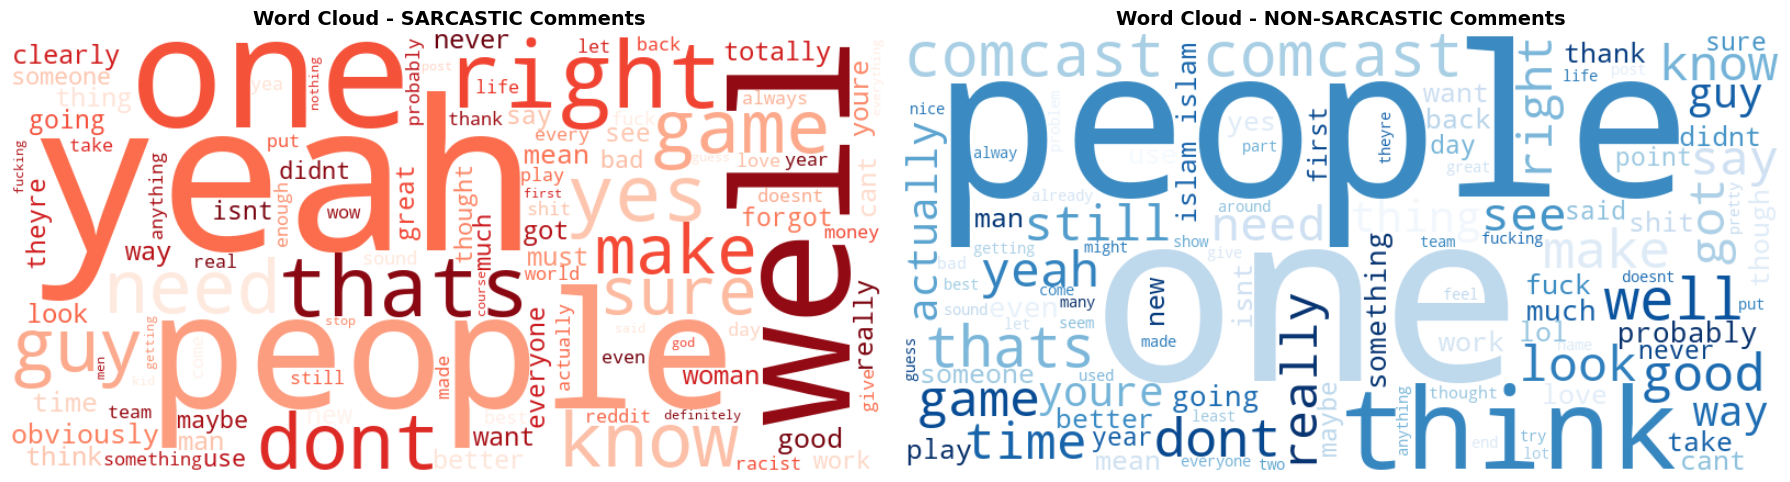

In [66]:
# Separate sarcastic and non-sarcastic comments
sarcastic_texts = ' '.join(df_sample[df_sample['label'] == 1]['cleaned_text'].values)
non_sarcastic_texts = ' '.join(df_sample[df_sample['label'] == 0]['cleaned_text'].values)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Sarcastic word cloud
wc_sarcastic = WordCloud(width=800, height=400, 
                         background_color='white',
                         colormap='Reds',
                         max_words=100).generate(sarcastic_texts)
axes[0].imshow(np.array(wc_sarcastic.to_image()), interpolation='bilinear')
axes[0].set_title('Word Cloud - SARCASTIC Comments', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Non-sarcastic word cloud
wc_non_sarcastic = WordCloud(width=800, height=400,
                              background_color='white',
                              colormap='Blues',
                              max_words=100).generate(non_sarcastic_texts)
axes[1].imshow(np.array(wc_non_sarcastic.to_image()), interpolation='bilinear')
axes[1].set_title('Word Cloud - NON-SARCASTIC Comments', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Sample Prediction

In [135]:
# Get some sample predictions
sample_indices = [1, 50, 103, 138, 170]


print("SAMPLE PREDICTIONS")
print()

for idx in sample_indices:
    actual = "SARCASTIC" if y_test.iloc[idx] == 1 else "NON-SARCASTIC"
    pred_lr = "SARCASTIC" if y_pred_lr[idx] == 1 else "NON-SARCASTIC"
    pred_rf = "SARCASTIC" if y_pred_rf[idx] == 1 else "NON-SARCASTIC"
    text = X_test.iloc[idx][:150] + "..." if len(X_test.iloc[idx]) > 150 else X_test.iloc[idx]
    
    print(f"\nSample {idx+1}:")
    print(f"Text: {text}")
    print(f"Actual Label: {actual}")
    print(f"LR Prediction: {pred_lr} ")
    print(f"RF Prediction: {pred_rf} ")
    print()

SAMPLE PREDICTIONS


Sample 2:
Text: wonder geas shady past doughnut thief brought spanish police
Actual Label: SARCASTIC
LR Prediction: SARCASTIC 
RF Prediction: NON-SARCASTIC 


Sample 51:
Text: damn obamas fault letting illegals get liberal vote destroy america liberalismohand infect ebola declare marshal law reason take away white right
Actual Label: SARCASTIC
LR Prediction: SARCASTIC 
RF Prediction: SARCASTIC 


Sample 104:
Text: progression essential boss total crap heap
Actual Label: SARCASTIC
LR Prediction: SARCASTIC 
RF Prediction: NON-SARCASTIC 


Sample 139:
Text: yeah screw taking advantage stupidity
Actual Label: SARCASTIC
LR Prediction: SARCASTIC 
RF Prediction: SARCASTIC 


Sample 171:
Text: cheer
Actual Label: NON-SARCASTIC
LR Prediction: NON-SARCASTIC 
RF Prediction: NON-SARCASTIC 



## SUMMARY

In [70]:
print(f"Dataset Information:")
print(f"   - Original Dataset Size: 1,010,826 comments")
print(f"   - Sampled Dataset Size: 100,000 comments")
print(f"   - After Cleaning: {len(df_sample):,} comments")
print(f"   - Training Set: {len(X_train):,} samples")
print(f"   - Testing Set: {len(X_test):,} samples")
print(f"   - TF-IDF Features: {X_train_tfidf.shape[1]:,}")
print()
print(f"Model Performance:")
print(f"\n   Logistic Regression:")
print(f"      Accuracy:  {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")
print(f"      Precision: {lr_precision:.4f}")
print(f"      Recall:    {lr_recall:.4f}")
print(f"      F1-Score:  {lr_f1:.4f}")
print(f"      ROC-AUC:   {roc_auc_lr:.4f}")
print()
print(f"\n   Random Forest:")
print(f"      Accuracy:  {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")
print(f"      Precision: {rf_precision:.4f}")
print(f"      Recall:    {rf_recall:.4f}")
print(f"      F1-Score:  {rf_f1:.4f}")
print(f"      ROC-AUC:   {roc_auc_rf:.4f}")
print()
print(f"Best Model: {best_model}")
print(f"   Best Accuracy: {comparison['Accuracy'].max():.4f} ({comparison['Accuracy'].max()*100:.2f}%)")

Dataset Information:
   - Original Dataset Size: 1,010,826 comments
   - Sampled Dataset Size: 100,000 comments
   - After Cleaning: 98,670 comments
   - Training Set: 78,936 samples
   - Testing Set: 19,734 samples
   - TF-IDF Features: 5,000

Model Performance:

   Logistic Regression:
      Accuracy:  0.6604 (66.04%)
      Precision: 0.6762
      Recall:    0.6265
      F1-Score:  0.6504
      ROC-AUC:   0.7189


   Random Forest:
      Accuracy:  0.6294 (62.94%)
      Precision: 0.7035
      Recall:    0.4582
      F1-Score:  0.5549
      ROC-AUC:   0.6857

Best Model: Logistic Regression
   Best Accuracy: 0.6604 (66.04%)
